In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


In [2]:
import DarkVerse as dv


In [19]:

# Define the home directory
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Load Catalog Data
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits")  
t = Table.read(fits_file_path)

masked_file_path = os.path.join(thesis_path, "COSMOS_masked_cat.fits")  
t3 = Table.read(masked_file_path)

# Join tables on 'id'
t = join(t, t3, keys='id')
t.rename_column('ra_1', 'ra')
t.rename_column('dec_1', 'dec')

# Load Randoms
fits_random = os.path.join(thesis_path, "COSMOS_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'bootstrap'
}

z_min=0.2
z_max=0.4
SM_min=8
SM_max=9

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
print(f"w_theta: {results['w_theta']}")
print(f"DD counts: {results['dd_counts']}")
print(f"DR counts: {results['dr_counts']}")
print(f"RR counts: {results['rr_counts']}")


Power Law Parameters (A, gamma): [0.00770844 0.52052666]

w_theta: [ 3.42733390e-02  1.31163214e-01  5.18558552e-02  2.14542008e-01
  4.56676664e-02  2.33741214e-01  1.71849901e-01  2.05445292e-01
  1.96394602e-01  8.80499250e-02  4.60236387e-02  8.32084355e-02
  2.51920558e-02  1.40411534e-01  1.06079863e-01  6.43204460e-02
  1.02949903e-01  3.65139678e-02  8.08514384e-02  2.28309900e-02
  5.79628560e-02  5.90721895e-02  4.51076656e-02  2.82083569e-02
  1.88434981e-02  5.05558116e-02  2.59346063e-02  3.63265715e-02
  4.26685676e-02  3.81438477e-02  3.41644232e-02  3.92158569e-02
  1.40339830e-02  3.41791840e-02  2.22534163e-02  2.48802984e-02
  8.74075494e-03  2.22650622e-02  2.53388616e-02  1.50342334e-02
  2.19550640e-03  1.11666517e-02  8.26786985e-04  8.37148877e-03
  9.81746788e-03  1.30142279e-02  4.01691743e-03  5.79850701e-03
  1.48753781e-03  5.76648257e-03 -5.23399665e-05 -1.45363759e-03
 -8.42310671e-05 -8.06280747e-03 -8.76295817e-03 -4.24435812e-03
 -3.70563213e-03 -8.607

Errors on w_theta: [ 0.28786443  0.26523242  0.28223399  0.28067722  0.26940062  0.27655584
  0.27033028  0.26393475  0.27296489  0.26623438  0.26802392  0.26942354
  0.27185816  0.26753946  0.26889287  0.26108236  0.26610125  0.26402791
  0.26180692  0.2620783   0.26073613  0.2597033   0.26015558  0.25455303
  0.25375886  0.25351579  0.24886958  0.24327263  0.23857513  0.22984346
  0.22360211  0.21414332  0.20453381  0.19507579  0.17923821  0.16343054
  0.15255783  0.13946473  0.1314512   0.12871148  0.12491812  0.12001982
  0.11437795  0.1078358   0.10001436  0.09636506  0.09315778  0.09184664
  0.09054011  0.08842674  0.08330557  0.0851339   0.09111417  0.09158026
  0.09038863  0.09022495  0.08402647  0.09081466  0.07535706  0.1029854
  0.10840251  0.16260535  0.31246491 30.80074178]


/tmp/ipykernel_2956661/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


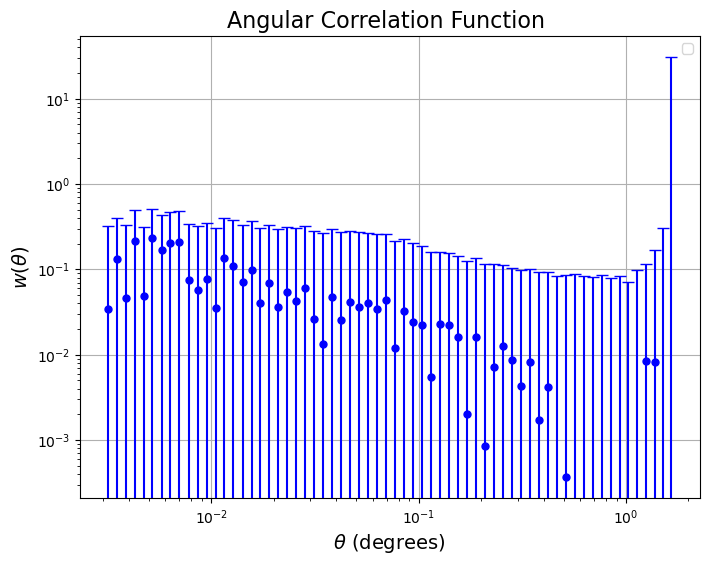

In [18]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


In [14]:
gg = subsample.compute_gg()  # Call the method inside the class



In [7]:


matter_correlation = gg.angular_corr_matter  # Matter-matter correlation
galaxy_correlation = gg.angular_corr_gal  # Galaxy-galaxy correlation



AttributeError: 'NoneType' object has no attribute 'angular_corr_matter'

In [15]:
mask = (theta_values >= 0.1) & (theta_values <= 0.4)


In [17]:
bias_est= dv.BiasEstimator(gg.angular_corr_gal, w_theta_values, w_theta_errors, results['rr_counts'], mask)

AttributeError: 'NoneType' object has no attribute 'angular_corr_gal'